In [1]:
import duckdb
import pyarrow.dataset as ds
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from models.eta_model_trainer import ETAModelTrainer
from lightgbm import LGBMRegressor
import tempfile
import numpy as np
import random
import shap
import matplotlib.pyplot as plt
import seaborn as sns

2023-03-07 03:22:48,256 - youconfigme.youconfigme - INFO - searching for config on /home/dml/proyectos/bicisba/research/models/settings.ini
2023-03-07 03:22:48,257 - youconfigme.youconfigme - INFO - searching for config on /home/dml/proyectos/bicisba/research/settings.ini


In [2]:
dataset = ds.dataset("data/status", format="parquet", partitioning="hive")
con = duckdb.connect()
con = con.register("status", dataset)

In [3]:
station_ids = con.execute("select distinct(station_id) from status where status = 'IN_SERVICE'").df()["station_id"].values
len(station_ids)

450

In [54]:
%%time
batch_size = 100

with tempfile.TemporaryDirectory() as tmpdirname:
    print(tmpdirname)
    for batch_start in range(0, len(station_ids), batch_size):
        df_query = f"""
        select
            station_id,
            hour,
            dayofweek(make_timestamp(year, month, day, hour, minute, 0.0)) as dow,
            num_bikes_available,
            num_bikes_disabled,
            num_docks_available,
            num_docks_disabled,
            status,
        """
        df_query += "".join([
            f"""minute(lead(make_timestamp(year, month, day, hour, minute, 0.0), {i}) over (
                partition by station_id
                order by make_timestamp(year, month, day, hour, minute, 0.0) asc
            ) - make_timestamp(year, month, day, hour, minute, 0.0)) as minutes_bt_check_{i},
            lead(num_bikes_available, {i}) over (
                partition by station_id
                order by make_timestamp(year, month, day, hour, minute, 0.0) asc
            ) as remaining_bikes_available_{i},"""
            for i in list(range(1, 7)) + list(range(7, 18, 3))])
        df_query += f"""
        from
            status
        where
            year = 2022 and
            month = 10 and
            station_id IN (
        """
        df_query += " , ".join([str(s) for s in station_ids[batch_start:batch_start+batch_size]])
        df_query += """) and
            status = 'IN_SERVICE'"""
        df_complete = con.execute(df_query).df()
        dfs_to_concat = []
        for i in list(range(1, 7)) + list(range(7, 18, 3)):
            dfs_to_concat.append(df_complete[["station_id", "hour", "dow", "num_bikes_available", "num_bikes_disabled", "num_docks_available",
                                    "num_docks_disabled", "status",f"minutes_bt_check_{i}",
                                    f"remaining_bikes_available_{i}"]].rename(columns={f"minutes_bt_check_{i}": "minutes_bt_check",
                                                                                    f"remaining_bikes_available_{i}": "remaining_bikes_available"}))

        df_complete = pd.concat(dfs_to_concat).dropna()
        df_complete = df_complete[(df_complete["remaining_bikes_available"]>df_complete["num_bikes_available"]) & (df_complete["num_bikes_available"]<=2)]
        df_complete.to_csv(tmpdirname+f"/{batch_start}.csv")
        del df_complete

    dfs_to_concat = []
    for batch_start in range(0, len(station_ids), batch_size):
        dfs_to_concat.append(pd.read_csv(tmpdirname+f"/{batch_start}.csv"))

    df_complete = pd.concat(dfs_to_concat)

print(f"dataset size {len(df_complete)}")

/tmp/tmph4mei13s
dataset size 3241365
CPU times: user 1min 59s, sys: 34.9 s, total: 2min 33s
Wall time: 2min 2s


In [55]:
df_complete.to_csv("eta_complete.csv")

In [2]:
df_complete = pd.read_csv("eta_complete.csv")

## Test Ridge regressor

In [3]:
FEATURES_ORDER = ["hour", "dow", "num_bikes_disabled", "num_docks_available", "num_docks_disabled"]
TARGET = "minutes_bt_check"
TEST_SIZE = 0.1

In [4]:
station_ids = df_complete["station_id"].unique()

random.seed(42)
stations_for_comp = random.sample(list(station_ids), k=20)

maes = []
all_y_test = []
all_y_pred = []
for station_id in stations_for_comp:
    station_ds = df_complete[df_complete["station_id"] == station_id]
    X_train, X_test, y_train, y_test = train_test_split(station_ds[FEATURES_ORDER].values, station_ds[TARGET].values, test_size=TEST_SIZE, shuffle=True)
    if len(station_ds[TARGET].unique()) == 1:
        y_train[0] = 0
        y_test[0] = 0
    rr_pipeline = make_pipeline(ColumnTransformer([("ohe",  OneHotEncoder(sparse=False), [0, 1]), ("ss",  StandardScaler(), slice(2,5))]),
                            RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]))
    rr_pipeline.fit(X_train, y_train)
    maes.append(mean_absolute_error(y_test, rr_pipeline.predict(X_test)))
    all_y_test.extend(list(y_test))
    all_y_pred.extend(list(rr_pipeline.predict(X_test)))

In [5]:
mean_absolute_error(all_y_test, all_y_pred), np.mean(maes), np.std(maes)

(4.199312751765742, 4.194737474530147, 0.06977196817492072)

## Test MLPRegressor

In [3]:
FEATURES_ORDER = ["hour", "dow", "num_bikes_disabled", "num_docks_available", "num_docks_disabled"]
TARGET = "minutes_bt_check"
TEST_SIZE = 0.1

In [4]:
maes = []
all_y_test = []
all_y_pred = []
for station_id in stations_for_comp:
    station_ds = df_complete[df_complete["station_id"] == station_id]
    X_train, X_test, y_train, y_test = train_test_split(station_ds[FEATURES_ORDER].values, station_ds[TARGET].values, test_size=TEST_SIZE, shuffle=True)
    if len(station_ds[TARGET].unique()) == 1:
        y_train[0] = 0
        y_test[0] = 0
    mlp_pipeline = make_pipeline(ColumnTransformer([("ohe",  OneHotEncoder(sparse=False), [0, 1]), ("ss",  StandardScaler(), slice(2,5))]),
                            MLPRegressor((128, 128, 128)))
    mlp_pipeline.fit(X_train, y_train)
    maes.append(mean_absolute_error(y_test, mlp_pipeline.predict(X_test)))
    all_y_test.extend(list(y_test))
    all_y_pred.extend(list(mlp_pipeline.predict(X_test)))

In [5]:
mean_absolute_error(all_y_test, all_y_pred), np.mean(maes), np.std(maes)

(4.076463070073206, 4.08534100011571, 0.08184645828035562)

## Test LGBMRegressor

In [6]:
station_ids = df_complete["station_id"].unique()

models = []
X_for_test = []
maes = []
all_y_test = []
all_y_pred = []
for station_id in stations_for_comp:
    station_ds = df_complete[df_complete["station_id"] == station_id]
    X_train, X_test, y_train, y_test = train_test_split(station_ds[FEATURES_ORDER].values, station_ds[TARGET].values, test_size=TEST_SIZE, shuffle=True)
    if len(station_ds[TARGET].unique()) == 1:
        y_train[0] = 0
        y_test[0] = 0
    lgbm_pipeline = make_pipeline(ColumnTransformer([("ohe",  OneHotEncoder(sparse=False), [0, 1]), ("ss",  StandardScaler(), slice(2,5))]),
                            LGBMRegressor())
    lgbm_pipeline.fit(X_train, y_train)
    models.append(lgbm_pipeline)
    X_for_test.append(X_test)
    maes.append(mean_absolute_error(y_test, lgbm_pipeline.predict(X_test)))
    all_y_test.extend(list(y_test))
    all_y_pred.extend(list(lgbm_pipeline.predict(X_test)))

In [7]:
mean_absolute_error(all_y_test, all_y_pred), np.mean(maes), np.std(maes)

(4.088081676370118, 4.099507380100647, 0.09027757406006823)

## Shap values

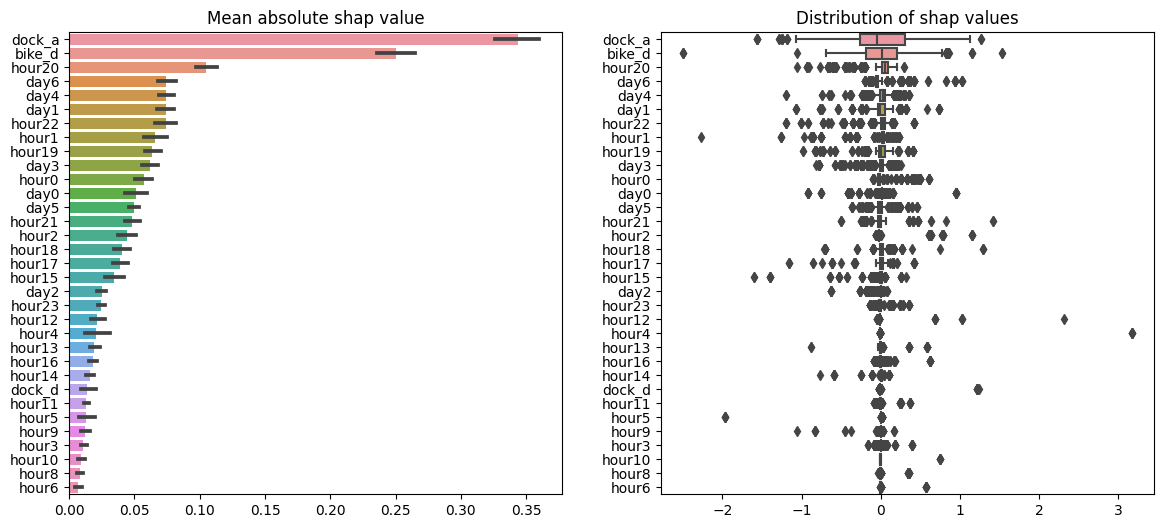

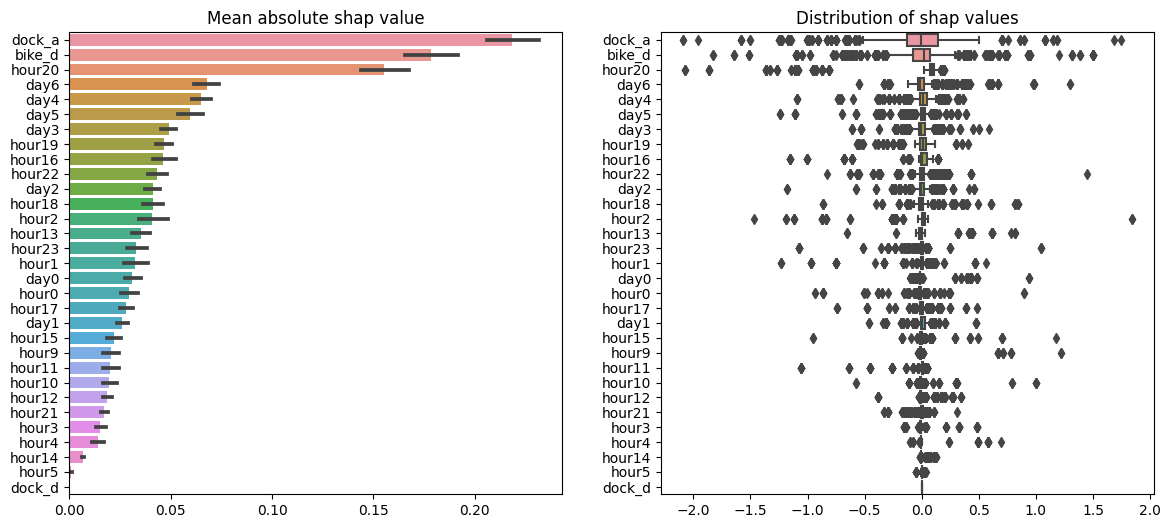

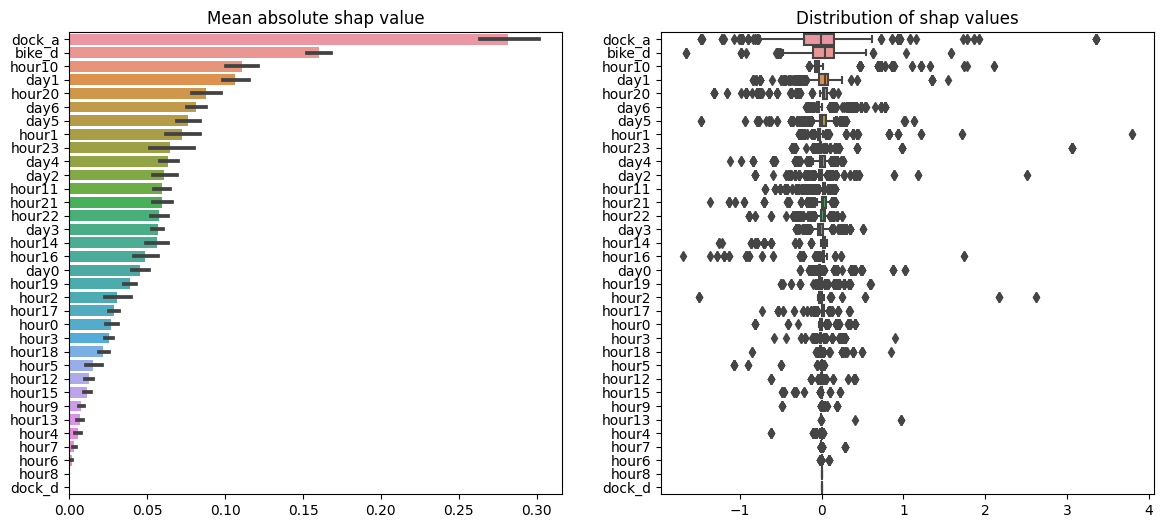

In [35]:
for i in range(3):
    feature_names = [(col.replace(".0", "").replace("ohe__x0_", "hour").replace("ohe__x1_", "day").replace("ss__x2", "bike_d")
    .replace("ss__x3", "dock_a").replace("ss__x4", "dock_d"))
    for col in models[i]["columntransformer"].get_feature_names_out()]
    explainer = shap.TreeExplainer(models[i]["lgbmregressor"], feature_names=feature_names)
    X_test = models[i]["columntransformer"].transform(X_for_test[i])
    shap_values = explainer(X_test)

    # raw look at shap values
    shap_df=pd.DataFrame(shap_values.values, columns=shap_values.feature_names)
    columns = shap_df.apply(np.abs).mean().sort_values(ascending=False).index
    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    sns.barplot(data=shap_df[columns].apply(np.abs), orient='h', 
                ax=ax[0])
    ax[0].set_title("Mean absolute shap value")
    sns.boxplot(data=shap_df[columns], orient='h', ax=ax[1])
    ax[1].set_title("Distribution of shap values");
    plt.show()

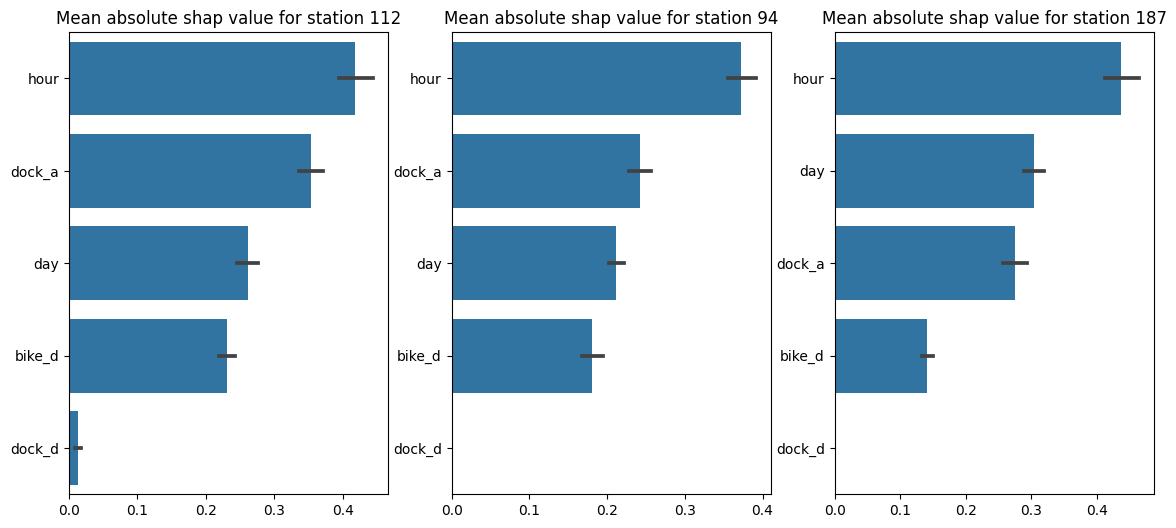

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(14,6))
for i in range(3):
    explainer = shap.TreeExplainer(models[i]["lgbmregressor"])
    X_test = models[i]["columntransformer"].transform(X_for_test[i])
    shap_values = explainer(X_test)

    new_shap_values = []
    for values in shap_values.values:
        h = len([1 for c in models[i]["columntransformer"].get_feature_names_out() if c.startswith("ohe__x0")])
        d = len([1 for c in models[i]["columntransformer"].get_feature_names_out() if c.startswith("ohe__x1")])
        values_split = np.split(values , np.cumsum([h,d,1,1]))    
        values_sum = [sum(l) for l in values_split]
        new_shap_values.append(values_sum)

    # raw look at shap values
    shap_df=pd.DataFrame(new_shap_values, columns=["hour", "day", "bike_d", "dock_a", "dock_d"])
    columns = shap_df.apply(np.abs).mean().sort_values(ascending=False).index
    sns.barplot(data=shap_df[columns].apply(np.abs), orient='h', color="tab:blue", ax=ax[i])
    ax[i].set_title(f"Mean absolute shap value for station {stations_for_comp[i]}")